# *Analysis of Churn for Prominent Rideshare Company*

## Load all potential modules required for analysis

In [13]:
import numpy as np
import pandas as pd
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea

import statsmodels.discrete.discrete_model as sm
from scipy import interp

from sklearn.metrics import make_scorer, log_loss, confusion_matrix, accuracy_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


%matplotlib inline

## Exploration of base datasets 

In [144]:
df_churn = pd.read_csv("data/churn.csv")

In [8]:
df_churn_train = pd.read_csv("data/churn_train.csv")

In [9]:
df_churn_test = pd.read_csv("data/churn_test.csv")

In [60]:
df_churn.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [30]:
churn_train.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

In [31]:
df_churn_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null object
phone                     39681 non-null object
signup_date               40000 non-null object
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.4+ MB


In [148]:
df_churn.isna().sum() 

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [147]:
df_churn_train.std()

avg_dist                   5.708056
avg_rating_by_driver       0.448088
avg_rating_of_driver       0.614810
avg_surge                  0.222427
surge_pct                 20.014008
trips_in_first_30_days     3.811289
luxury_car_user            0.484424
weekday_pct               37.089619
dtype: float64

In [71]:
print("Average driver rating: ", df['avg_rating_of_driver'].mean())

print("Average rating of rider: ", df['avg_rating_by_driver'].mean())

Average driver rating:  4.601696940726505
Average rating of rider:  4.777433606104486


In [219]:
grouped_phone = df.groupby(["phone", "Churn?"])

grouped_phone.count()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  \
phone   Churn?                                                         
Android 0           9702                  9702                  9702   
        1           2351                  2351                  2351   
iPhone  0          15440                 15440                 15440   
        1          12188                 12188                 12188   

                avg_surge   city  last_trip_date  signup_date  surge_pct  \
phone   Churn?                                                             
Android 0            9702   9702            9702         9702       9702   
        1            2351   2351            2351         2351       2351   
iPhone  0           15440  15440           15440        15440      15440   
        1           12188  12188           12188        12188      12188   

                trips_in_first_30_days  luxury_car_user  weekday_pct  
phone   Churn?                                                        
Android 0                         9702             9702         9702  
        1                         2351             2351         2351  
iPhone  0                        15440            15440        15440  
        1                        12188            12188        12188

In [78]:
# Add in 'Churn?' feature based on client specifications plus more. For the moment, I will be removing 
# NaNs associated with phone (due to insignificant number of data points) and imputing means to both 
# 'avg_rating...' features. From below pairplot, I can see that churn is grouped around where the average 
# of ratings would reside. As such I feel such an imputation would not be a detriment to the overall analysis.
# Lastly, will be changing 'luxury_car_user' to int from str that it may better used in analysis and not need 
# one-hot encoding as 'city' will later on.

def prep_df(filepath):
    
    # Function to prepare a dataset based on client specifications of churn and appropriately modifying features
    # for analysis as specified above.
    
    df = pd.read_csv(filepath)

    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
    df['Churn?'] = df['last_trip_date'] > pd.Timestamp('2014-06-01')
    df['Churn?'] = df['Churn?'].astype(int)

    df.loc[df['avg_rating_of_driver'].isna(), 'avg_rating_of_driver'] = df['avg_rating_of_driver'].mean()
    df.loc[df['avg_rating_by_driver'].isna(), 'avg_rating_by_driver'] = df['avg_rating_by_driver'].mean()

    df['luxury_car_user'] = df['luxury_car_user'].astype(int)

    df.dropna(inplace = True)
    
    return df

df = prep_df("data/churn_train.csv")

In [142]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,Churn?
0,6.94,5.0,5.000000,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,0,100.0,0
1,8.06,5.0,5.000000,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,1,0.0,0
2,21.50,4.0,4.601697,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,1,100.0,0
3,9.46,5.0,4.601697,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,0,100.0,0
4,13.77,5.0,4.601697,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,0,100.0,0


/Users/birdshaw/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/birdshaw/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/birdshaw/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/birdshaw/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


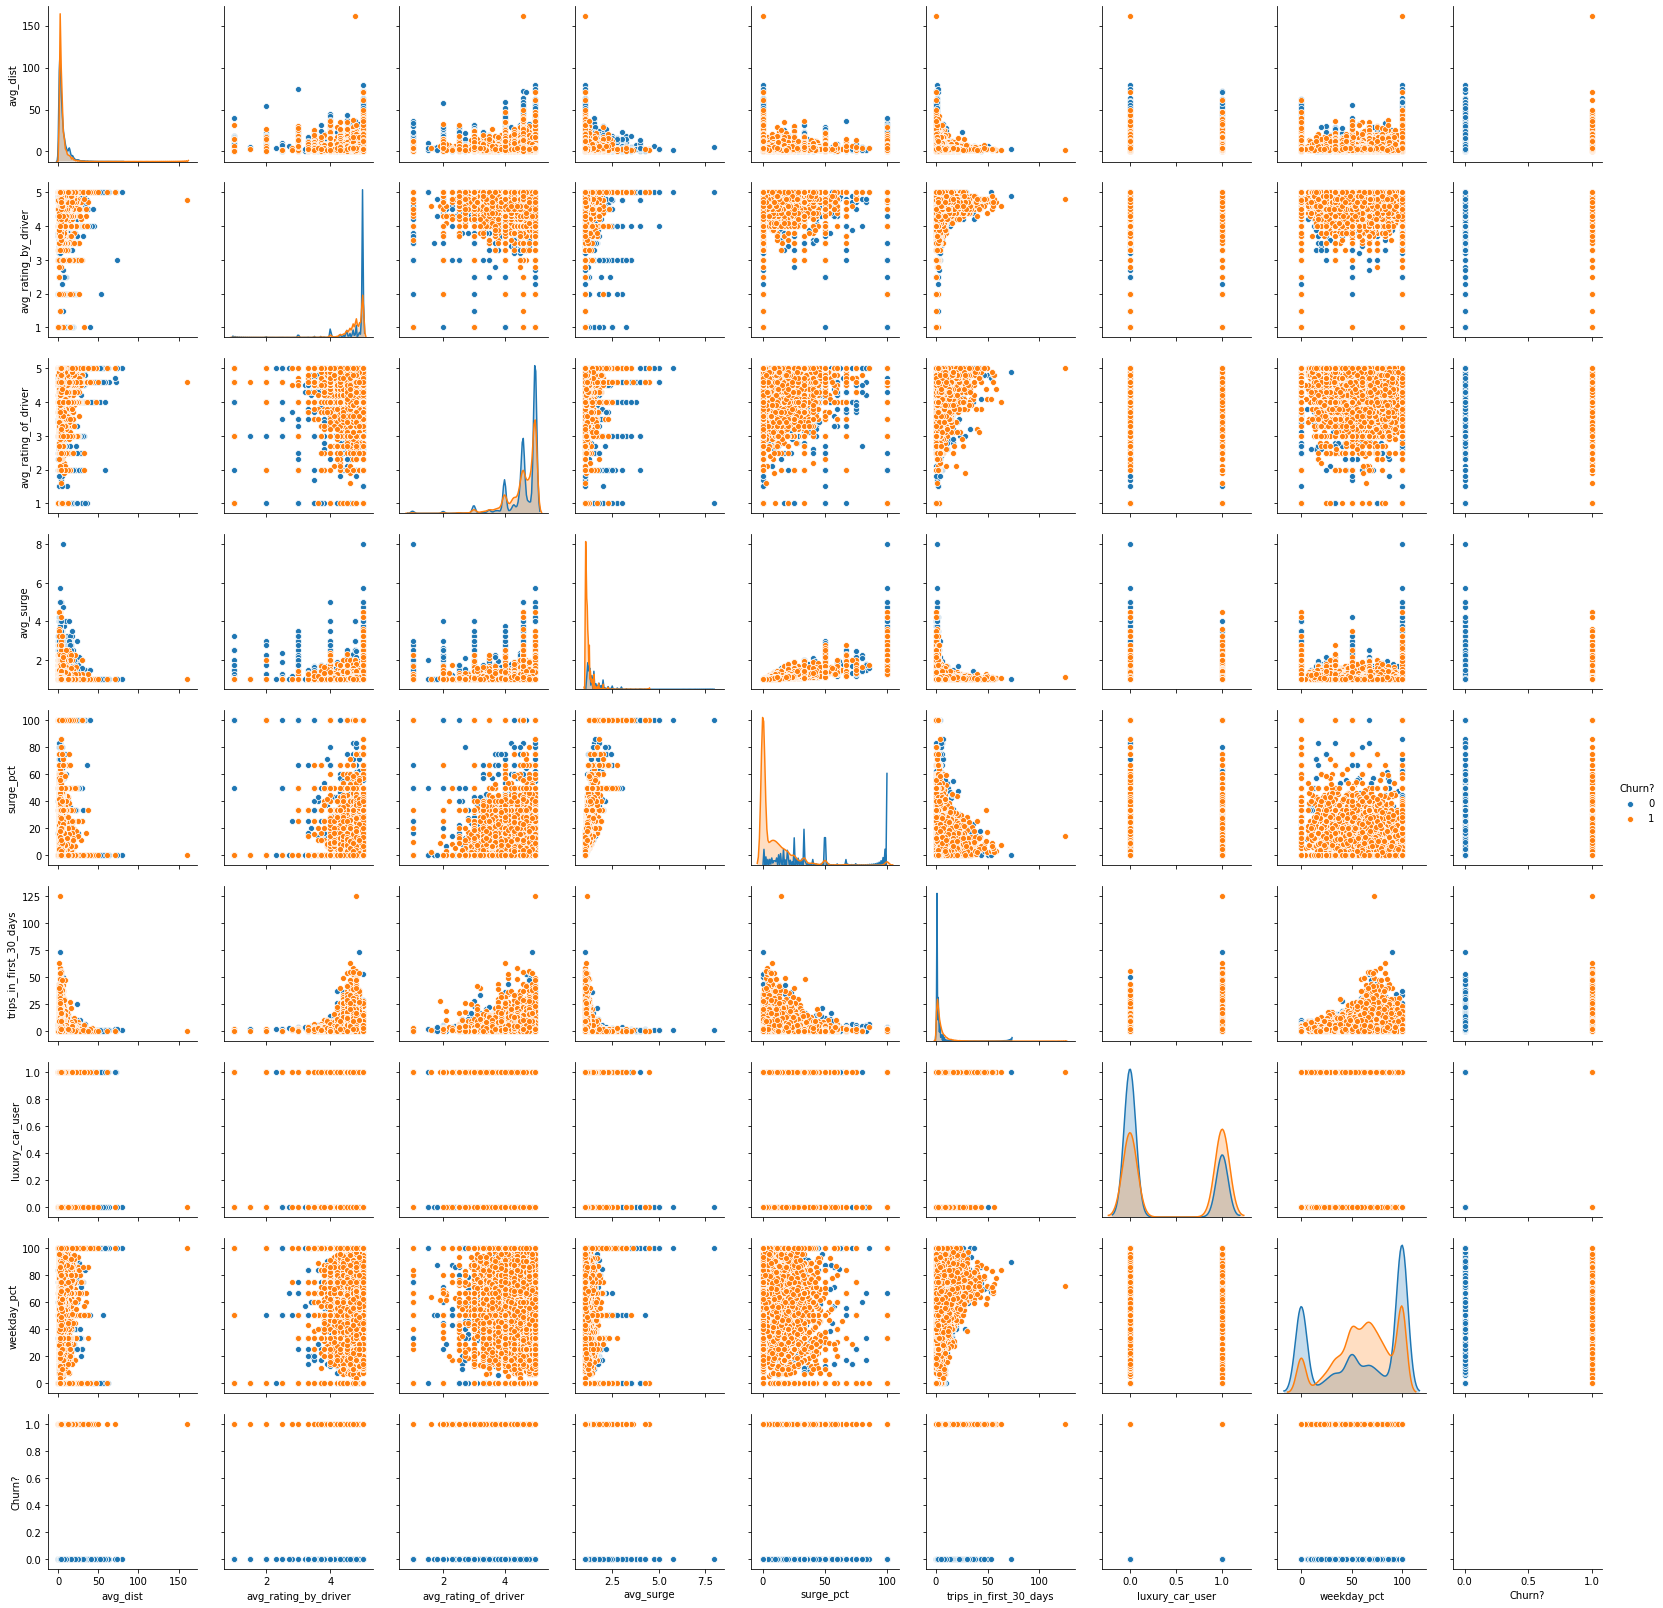

In [85]:
sea.pairplot(df, hue = 'Churn?')

From the pairplot above you can clearly see the intensity of churn arising from the features avg_surge, surge_pct, and avg_dist. This shows us a few things: churn seems to predominantly take place for users who take a trips averaging less than 20 miles, churning users seem to have taken trips with an average surge multiplier below 2, and that churned users rarely took trips where surges multipliers were greater above normal ( > 1 ).

There are a few other interesting relationships that can be seen from this but these will be noted explicitly first as they stand out the most. 

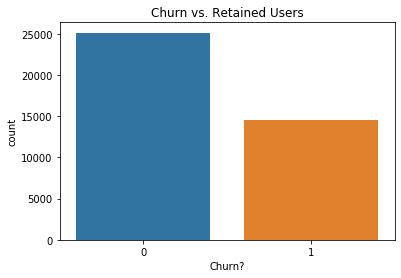

In [92]:
sea.countplot(x="Churn?", data=df).set_title("Churn vs. Retained Users");

* **See that there is an unequal amount of 'Churn?' datapoints which will have to be addressed in modeling.**



In [80]:
df['Churn?'].value_counts()

0    25142
1    14539
Name: Churn?, dtype: int64

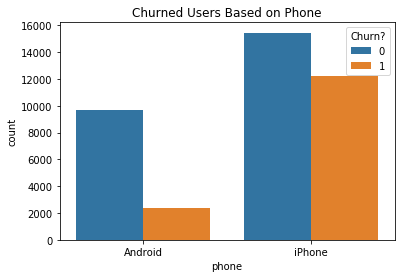

In [93]:
sea.countplot(x='phone', hue = "Churn?", data=df).set_title("Churned Users Based on Phone");

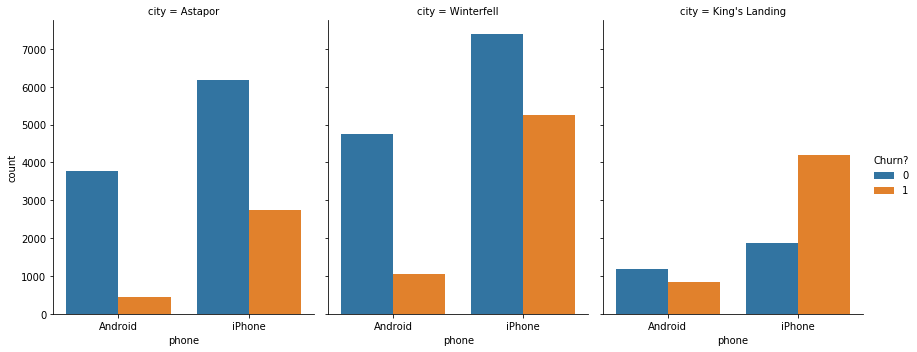

In [84]:
sea.catplot(x='phone', hue = "Churn?", col = 'city', data = df, kind = 'count',  aspect = .8)

We can see that there is not only a rather large difference between number of iPhone to Android users, but an even greater difference between users that churn based on phones. As such, this would appear to be a strong point in regards to potential cause of churn.
- Is there a significant difference between the application used by each phone? ( UX design, quality of app based on phone OS, etc ) 
- Is it an issue regarding number of actual Android/iPhone users found in each location? Or more likely an issue that surrounds the city itself? ( infrastructure, growth, primary industry, wealth, etc )

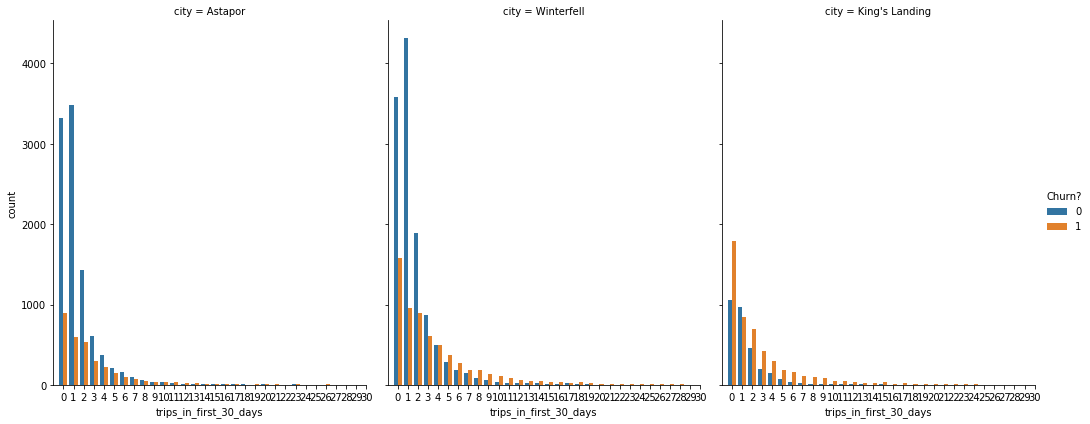

In [134]:
  
sea.catplot(x = 'trips_in_first_30_days', hue = "Churn?", col = 'city', data = df, kind = 'count', height = 6,
           aspect = .8)
plt.xlim(-1, 30);

It continues to show King's Landing leading in churns for the majority of days. I feel it more interesting that there is such a large number of users who took no trips in the first 30 days that were considered retained. Meaning that they simply downloaded the app, signed up, and then left the service completely unused for a minimun of 30 days. Certainly shows that there exists reason to reach out to this segment through email, incentivizing them with discounts or promos. 

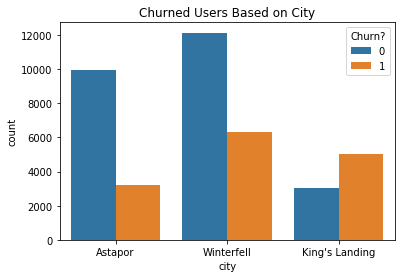

In [94]:
sea.countplot(x='city', hue = 'Churn?', data = df).set_title("Churned Users Based on City");

Though their real world names were changed due to data security, we can clearly see that King's Landing stands out for the number of churned users it contains. As such it would be most beneficial to look at King's Landing to see what is going on to cause such a spike. Additionally it would behoove us to further analyze in what ways Astapor is succeeding in retaining users. 

A few key questions that stand out <u>(though none are able to be answered with available data, only potentially inferred)</u>:
* Is the difference in churn related to a geographical difference in cities? Such as is one more spread out and the other denser leading to the need or superflousness of using a rideshare service.
* Type of industry within the city? Is it primarily focused on office workers needing to travel to and from the city? Is it more manufacturing based where many residents don't need a rideshare as they travel med-long distance to a plant? Is work from home encouraged amongst majority of employees at predominant companies in the respective cities?
* Wealth/level of the city? Meaning is the city more of a metropolis, predominantly suburban, in a growth state, or poor? Any of these would influence the usefulness and thereby retention of users for a rideshare company. 

## Finalize dataset and begin modeling.

Will use one-hot encoding on "city" to allow it to be useable by models. Apply standard scaler normalization to data and begin setting up a pipeline to begin modelling. 

In [22]:
def final_df(filepath):
    
    # Function takes previous dataset manipulations and applies them to provided dataset. Creating "Churn?" 
    # feature, modifying strings to integers, applies one-hot encoding, impute relevant means, and drops "phone"
    # NaNs and irrelevant columns.
    
    data = pd.read_csv(filepath)
    
    df = data.copy()

    df.loc[df['avg_rating_of_driver'].isna(), 'avg_rating_of_driver'] = df['avg_rating_of_driver'].mean()
    df.loc[df['avg_rating_by_driver'].isna(), 'avg_rating_by_driver'] = df['avg_rating_by_driver'].mean()

    df['luxury_car_user'] = df['luxury_car_user'].astype(int)
    
    df.dropna(inplace = True)
    
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
    df['Churn?'] = df['last_trip_date'] > pd.Timestamp('2014-06-01')
    df['Churn?'] = df['Churn?'].astype(int)
    
    df.drop(columns = ['signup_date', 'last_trip_date'], inplace = True)
    
    df = pd.get_dummies(df)
    
    return df


def importance_plot(fit_model, dataframe):
    
    # Function takes in a previously instantiated and fit model and dataset and produces an easily readable
    # plot of features importances
    
    m = fit_model
    n = 10
    feat_import = m.feature_importances_[:n]
    
    indices = np.argsort(feat_import)
    features = list(dataframe.columns[indices])
    
    plt.figure()
    plt.suptitle("Feature Importances", fontweight = 'bold', fontsize = 24)
    plt.barh(range(10), feat_import[indices], align='center')
    plt.yticks(range(10), features, fontsize = 16)
    

In [23]:
# Check it came out right.

df_final = final_df('data/churn_train.csv')

df_final.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,Churn?,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,6.94,5.0,5.000000,1.00,0.0,0,0,100.0,0,1,0,0,1,0
1,8.06,5.0,5.000000,1.00,0.0,2,1,0.0,0,1,0,0,1,0
2,21.50,4.0,4.601697,1.00,0.0,1,1,100.0,0,0,0,1,0,1
3,9.46,5.0,4.601697,2.75,100.0,1,0,100.0,0,0,0,1,1,0
4,13.77,5.0,4.601697,1.00,0.0,0,0,100.0,0,0,0,1,0,1


In [24]:
# Base dataset and targets for modeling

X = final_df('data/churn_train.csv')
y = X.pop('Churn?')

In [25]:
# Hold out dataset for final testing

ho_X = final_df("data/churn_test.csv")
ho_y = ho_X.pop("Churn?")

In [26]:
# Use stratify to make up for the class imbalance displayed in the previous exploration section

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### Logistic Regression 

In [195]:
scaler = StandardScaler()
std_features = scaler.fit_transform(X_train)

log_r = LogisticRegression()
log_r.fit(std_features, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [196]:
log_r_coefs = pd.DataFrame({"Log_Reg_Coeff": log_r.coef_[0]}, index = np.asarray(X.columns))
log_r_coefs.sort_values(by = "Log_Reg_Coeff", ascending = False)

,Log_Reg_Coeff
trips_in_first_30_days,0.460631
city_King's Landing,0.452993
luxury_car_user,0.438371
phone_iPhone,0.269370
surge_pct,0.055782
weekday_pct,0.034349
avg_surge,-0.020308
avg_rating_of_driver,-0.031761
city_Winterfell,-0.065219
avg_rating_by_driver,-0.070403


Can see from here potential importances of features shown by the positive coefficient values. However, this is also misleading considering based on how I might remove certain features I would wind up with varying coeff values leading to different correlations and thereby potential importances. Though more could be done, such as regularization, computing odds ratio, etc I believe that it would be more worthwhile and enlightening to move to models that elucidate feature importances outright. 

### Gradient Boosting Classifier, Grid Search, and Feature Importances

In [31]:
gbc = GradientBoostingClassifier()

shrink_parm = np.array([.08, .1, .14, .19])
n_est_parm = np.array([150, 200, 250, 400, 600])
depth_parm = np.array([3, 5, 7, 9])

parameters = {'learning_rate': shrink_parm,
             'n_estimators': n_est_parm,
             'max_depth': depth_parm}

model = gbc

gbc_clf = GridSearchCV(estimator=model,
                      param_grid = parameters,
                      cv = 10, n_jobs=-1, verbose=1)

gbc_clf.fit(X_train, y_train)

best_gbc = gbc_clf.best_estimator_

Fitting 10 folds for each of 80 candidates, totalling 800 fits


In [59]:
best_gbc.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(learning_rate=0.19, n_estimators=250)>

In [58]:
print("Accuracy of tuned Gradient Boosting Classifier on split training dataset:", best_gbc.score(X_test, y_test))

Accuracy of tuned Gradient Boosting Classifier on split training dataset: 0.7935691966535632


In [51]:
print("Accuracy of tuned Gradient Boosting Classifier on hold out dataset:", best_gbc.score(ho_X, ho_y))

Accuracy of tuned Gradient Boosting Classifier on hold out dataset: 0.7888743323591656


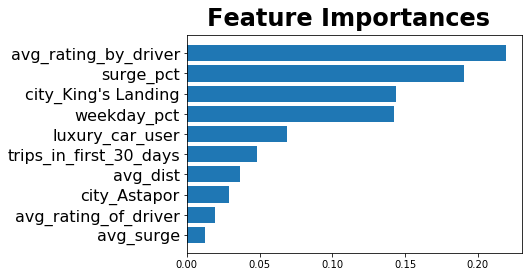

In [52]:
importance_plot(best_gbc, X)

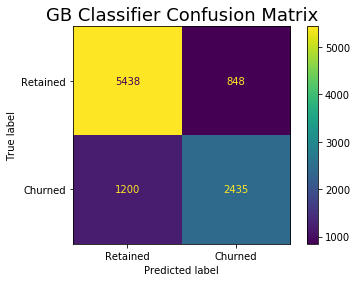

In [56]:
cm_gbc = plot_confusion_matrix(best_gbc, X_test, y_test, values_format = 'd', display_labels = ["Retained", "Churned"])
cm_gbc.ax_.set_title("GB Classifier Confusion Matrix", fontsize = 18)
cm_gbc;

In [53]:
y_pred_gb = best_gbc.predict(X_test)

print("GB Precision Score:", precision_score(y_test, y_pred_gb))
print("GB Recall Score:", recall_score(y_test, y_pred_gb))

GB Precision Score: 0.7416996649406031
GB Recall Score: 0.6698762035763411


### Random Forest Classifier, Grid Search, and Feature Importance

In [227]:
rf = RandomForestClassifier()

rf_GS = {'max_depth': [3, 5, 20],
        'max_features': ['sqrt', 'log2'],
        'min_samples_split': [2, 4],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False],
        'n_estimators': [10, 20, 40, 80, 200, 1000]}

model = rf

rf_params = GridSearchCV(estimator = model, param_grid = rf_GS, cv = 10, n_jobs = -1, verbose = 1)

rf_res = rf_params.fit(X_train, y_train)

best_rf = rf_res.best_estimator_

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 46.6min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 54.6min finished


In [231]:
best_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [237]:
print("Accuracy of tuned Random Forest Classifier on split training dataset:", best_rf.score(X_test, y_test))

Accuracy of tuned Random Forest Classifier on split training dataset: 0.7854046971071464


In [235]:
print("Accuracy of tuned Random Forest Classifier on hold out dataset:", best_rf.score(ho_X, ho_y))

Accuracy of tuned Random Forest Classifier on hold out dataset: 0.7818200141086366


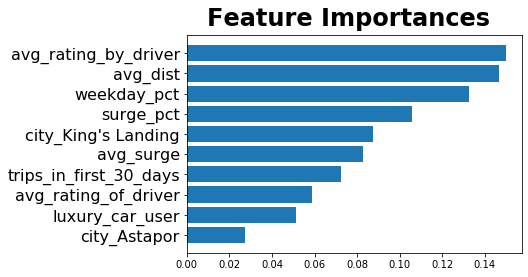

In [232]:
importance_plot(best_rf, X)

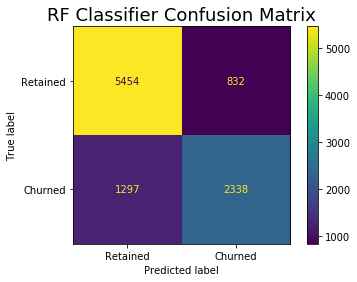

In [280]:
# Easily readable confusion matrix plot

cm = plot_confusion_matrix(best_rf, X_test, y_test, values_format = 'd', display_labels = ["Retained", "Churned"])
cm.ax_.set_title("RF Classifier Confusion Matrix", fontsize = 18)
cm;

In [285]:
y_pred_rf = best_rf.predict(X_test)

print("RF Precision Score:", precision_score(y_test, y_pred_rf))
print("RF Recall Score:", recall_score(y_test, y_pred_rf))

RF Precision Score: 0.7375394321766562
RF Recall Score: 0.643191196698762


### Recursive Feature Elimination

In [62]:
estimator = GradientBoostingClassifier(learning_rate = 0.19, n_estimators = 250)

selector = RFECV(estimator, n_jobs = -1)
selected = selector.fit(X_train, y_train)

selected

RFECV(estimator=GradientBoostingClassifier(learning_rate=0.19,
                                           n_estimators=250),
      n_jobs=-1)

In [74]:
for col, select, rank in zip(X.columns, selected.support_, selected.ranking_):
    
    print("{:^22} | {:^5} | {}".format(col, str(select), rank))

       avg_dist        | True  | 1
 avg_rating_by_driver  | True  | 1
 avg_rating_of_driver  | False | 2
      avg_surge        | False | 3
      surge_pct        | True  | 1
trips_in_first_30_days | True  | 1
   luxury_car_user     | True  | 1
     weekday_pct       | True  | 1
     city_Astapor      | True  | 1
 city_King's Landing   | True  | 1
   city_Winterfell     | False | 4
    phone_Android      | True  | 1
     phone_iPhone      | True  | 1


In [75]:
print("Accuracy with RFE'd Gradient Boosting Classifier on test set:", selected.score(X_test, y_test))
print("Accuracy with RFE'd Gradient Boosting Classifier on hold out set:", selected.score(ho_X, ho_y))

Accuracy with RFE'd Gradient Boosting Classifier on test set: 0.7956859187581897
Accuracy with RFE'd Gradient Boosting Classifier on hold out set: 0.7917968356343847


In [76]:
y_pred_rfe_gb = selected.predict(X_test)

print("RFE'd GBC Precision Score:", precision_score(y_test, y_pred_rfe_gb))
print("RFE'd GBC Recall Score:", recall_score(y_test, y_pred_rfe_gb))

RFE'd GBC Precision Score: 0.7454212454212454
RFE'd GBC Recall Score: 0.6718019257221458


## Conclusions:

As I went into deeper detail of my exploration in the previous sections where it was pertinant, I will attempt to keep this short. 

The primary goal from this client was to clean and explore the given data to find reasonable and actionable causes of churn. To potentially verify those causes and come up with possible solutions. In order to accomodate this, extensive exploration of the data was performed. From this was found some key points:
- From pairplots, large counts of churn could be seen for avg_surge, surge_pct, and avg_dist.
  - Specifically can see that churn occcurred for trips averageing less than 20 miles, trips with an average surge mulitplier below 2, and that churned users rarely took trips with a surge multiplier above 1.
* Significant difference between number of churned users using iPhone over Android. 
    * Could point to issues in design of application between two platforms, bugs present in each platform, or a something more to do with geographic differences (i.e. predominance of platform based on economics of location given iPhones are considered a luxury item)
* Keen difference not only of users between cities but specifically that King's Landing performed worse comparatively. 

In line with these findings explored more through visualizations, various ML algorithms were applied to the data to discover how well we could predict churn with given information and additionally verify causes off churn. To accomplish this, the use of Logistic Regression (LR), Gradient Boosting Classifier (GBC), Random Forest Classifier (RFC), and Recursive Feature Elimination (RFE) was used. 

Of these employed algorithms, the latter 3 were most helpful. Considering both the GBC and RFC have built in feature importance attributes, it is much easier to both discover the predictive power of our model as well as verify the relevant featrures of churn as per the clients desire. Lastly, RFE was utilized to gain any additional predictive power and provide a second opinion on feature importance.

From them we can see that the top 5 for GBC and RFC respectively:
* GBC: avg_rating_by_driver, surge_pct, city_King's Landing, weekday_pct, luxury_car_user
* RFC: avg_rating_by_driver, avg_dist, weekday_pct, surge_pct, city_King's Landing

These are all features that are verified as important with RFE aswell. 

From all of this information we can see what aspects of a user's ride is most important or most needing of attention to minimize their probability of churning. In this regard we can see many things. Evaluating the above charts we can find that though avg_rating_by_driver is important, the users who are retained or churned predominantly overlap in trends leading to little insight. But things such as surge_pct, avg_dist, weekday_pct, and city_King's Landing do show more stark differences between churned/retained users. Insight into the first two was touched on above. For the latter half we see that churned users took rides during weekdays 45-75% of the time and that King's Landing was rife with churning.

__Final Thoughts:__

Now, the goal becomes to look at this and decide how to focus our attention on future potentially churning users to keep them retained. In order to do so, it would be best to utilize the GBC model to find users with a high probability of churning based on the discussed factors. We then send them targeted promotions or coupons incentivizing continued use. Possibly even promos designed to push their usage habits into those more akin to retained users. Additional steps would be to analyze the apps for both Android and iPhone to see what discrepencies/problems exists to explain the churn difference. Lastly, we need more data to explore what is going on between the the cities of Astapor and King's Landing specifically. One is a model of retention and the other churn. Discovering this would be very beneficial for the creation of more improved model. 

If more information is desired, a presentation deck can be found [here](https://docs.google.com/presentation/d/1YStiAyLKIVlfP9Ic2L45AYjin81-3KKuZ4YjI0YKRkc/edit?usp=sharing)